# Imports

In [1]:
import os

os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import itertools

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query

# Statics

In [4]:
from src.data.data_statics import SQL_WIKI_DUMP, TEMP_DB

In [5]:
INFO_COLUMNS = [
    "summary_word_count",
    "body_word_count",
    "novelty_tokens",
    "novelty_bigrams",
    "novelty_trigrams",
    "semantic_similarity",
]

# Read data

In [6]:
query = """
    SELECT  ar.pageid
           ,ar.title
           ,ar.summary_word_count
           ,ar.body_word_count
           ,nov.novelty_tokens
           ,nov.novelty_bigrams
           ,nov.novelty_trigrams
           ,sm.semantic_similarity
           
    FROM wiki_article_novelty nov
    INNER JOIN article_level_info ar
        ON ar.pageid=nov.pageid
    INNER JOIN wiki_article_cosine_similarity sm
        ON ar.pageid=sm.pageid
"""

In [7]:
wiki_info_df = retrieve_query(query, out_f=SQL_WIKI_DUMP)
wiki_info_df = pd.DataFrame(
    wiki_info_df,
    columns=[
        "pageid",
        "title",
        "summary_word_count",
        "body_word_count",
        "novelty_tokens",
        "novelty_bigrams",
        "novelty_trigrams",
        "semantic_similarity",
    ],
)

In [8]:
assert len(wiki_info_df) == 1424051

# Evaluate distribution

In [9]:
wiki_info_df[["novelty_tokens", "novelty_bigrams", "novelty_trigrams",]] = wiki_info_df[
    ["novelty_tokens", "novelty_bigrams", "novelty_trigrams"]
].astype(float)

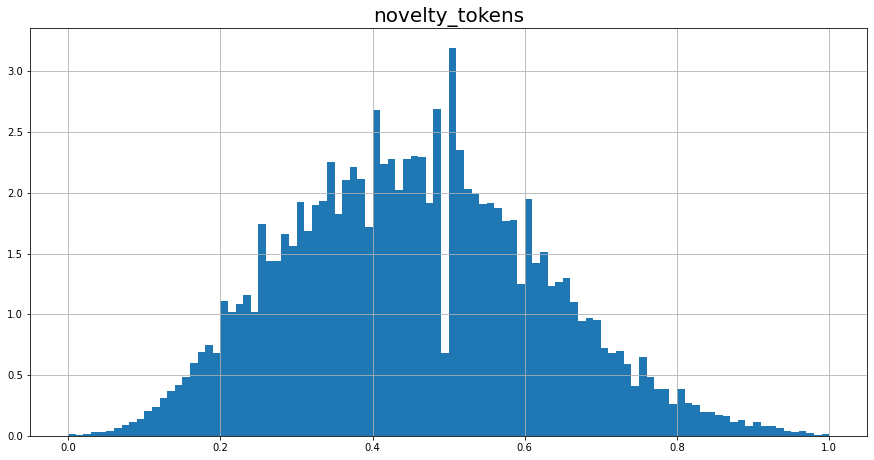

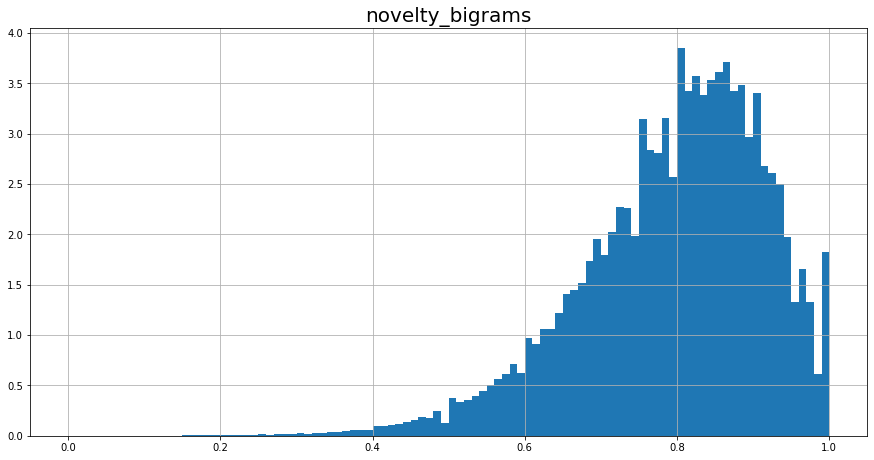

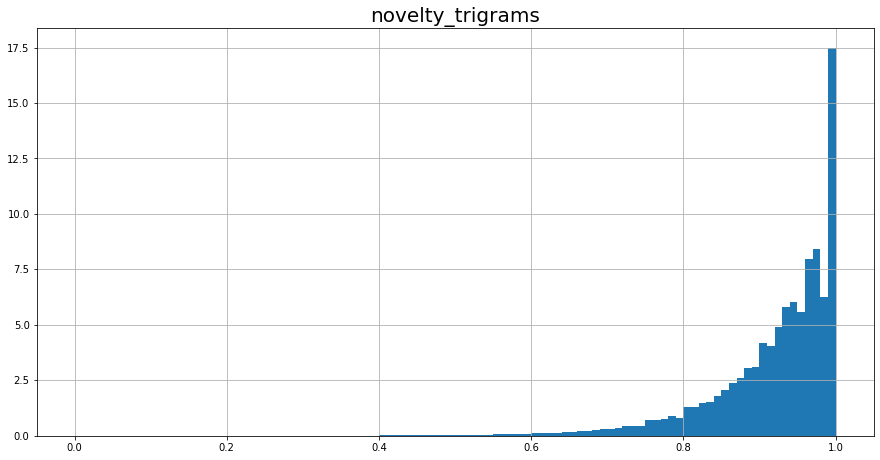

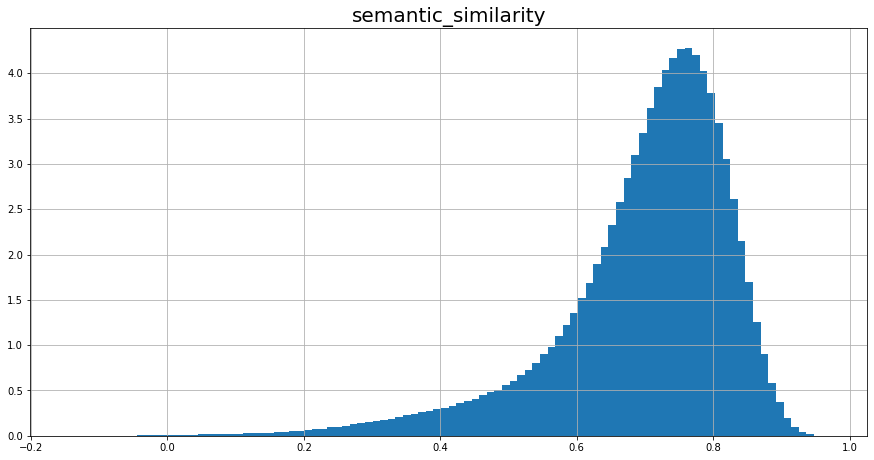

In [10]:
for var in [
    "novelty_tokens",
    "novelty_bigrams",
    "novelty_trigrams",
    "semantic_similarity",
]:
    plt.figure(figsize=(15, 7.5))
    plt.title(var, fontsize=20)
    wiki_info_df[var].hist(bins=100, density=True)
    plt.show()

In [11]:
wiki_info_df.describe()

,pageid,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
count,1.424051e+06,1.424051e+06,1.424051e+06,1.424051e+06,1.424051e+06,1.424051e+06,1.424051e+06
mean,2.515004e+07,1.113846e+02,9.756660e+02,4.563613e-01,7.949752e-01,9.192736e-01,6.980661e-01
std,2.129883e+07,7.731875e+01,8.778095e+02,1.661923e-01,1.212887e-01,8.571314e-02,1.290862e-01
min,1.200000e+01,4.000000e+01,2.500000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.454069e-01
25%,4.582285e+06,6.000000e+01,4.520000e+02,3.333333e-01,7.241379e-01,8.863636e-01,6.446057e-01
50%,2.107890e+07,8.500000e+01,7.000000e+02,4.509804e-01,8.125000e-01,9.431818e-01,7.256474e-01
75%,4.282306e+07,1.330000e+02,1.144000e+03,5.714286e-01,8.837209e-01,9.782609e-01,7.853432e-01
max,6.876322e+07,5.120000e+02,1.009100e+04,1.000000e+00,1.000000e+00,1.000000e+00,9.699446e-01


# Compare variables
## Compare correlation

In [12]:
relevant_combinations = [
    pair
    for pair in itertools.combinations(INFO_COLUMNS, 2)
    if (not (("novelty" in pair[0]) & ("novelty" in pair[1])))
    & (not (("count" in pair[0]) & ("count" in pair[1])))
]

In [13]:
for var1, var2 in itertools.combinations(INFO_COLUMNS, 2):
    corr, pval = pearsonr(wiki_info_df[var1], wiki_info_df[var2])
    print(f"{var1} - {var2} correlation of {corr:.3f} with p-value {pval:.3f}")

summary_word_count - body_word_count correlation of 0.762 with p-value 0.000
summary_word_count - novelty_tokens correlation of -0.140 with p-value 0.000
summary_word_count - novelty_bigrams correlation of -0.165 with p-value 0.000
summary_word_count - novelty_trigrams correlation of -0.121 with p-value 0.000
summary_word_count - semantic_similarity correlation of 0.177 with p-value 0.000
body_word_count - novelty_tokens correlation of -0.307 with p-value 0.000
body_word_count - novelty_bigrams correlation of -0.254 with p-value 0.000
body_word_count - novelty_trigrams correlation of -0.151 with p-value 0.000
body_word_count - semantic_similarity correlation of 0.106 with p-value 0.000
novelty_tokens - novelty_bigrams correlation of 0.837 with p-value 0.000
novelty_tokens - novelty_trigrams correlation of 0.652 with p-value 0.000
novelty_tokens - semantic_similarity correlation of -0.482 with p-value 0.000
novelty_bigrams - novelty_trigrams correlation of 0.902 with p-value 0.000
novel

## Joint distributions

In [14]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


def plot_joint(data, x_label, y_label, bins=(100, 100)):

    x = data[x_label]
    y = data[y_label]
    ax1 = sns.jointplot(x=x, y=y)
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)

    plt.hist2d(x, y, bins=bins, cmap=cm.jet, norm=LogNorm())
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    cbar_ax = ax1.fig.add_axes([1, 0.1, 0.03, 0.7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r"$\log_{10}$ density of points", fontsize=13)

    plt.show()

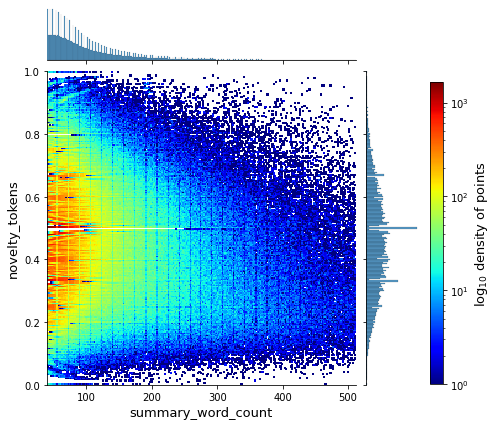

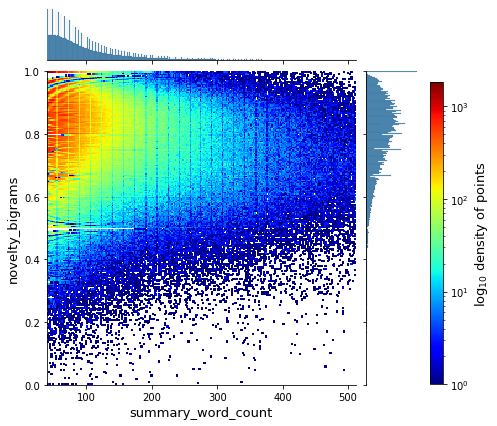

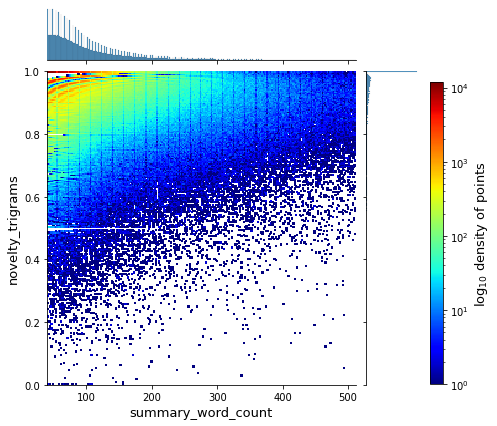

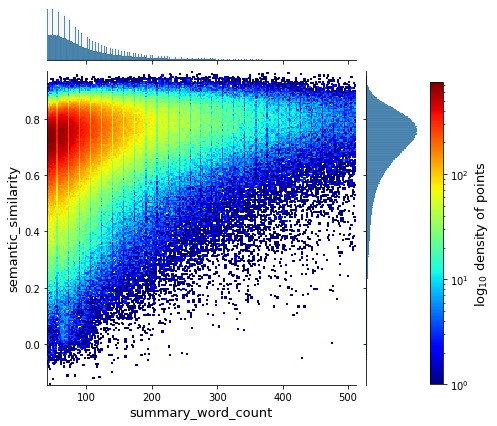

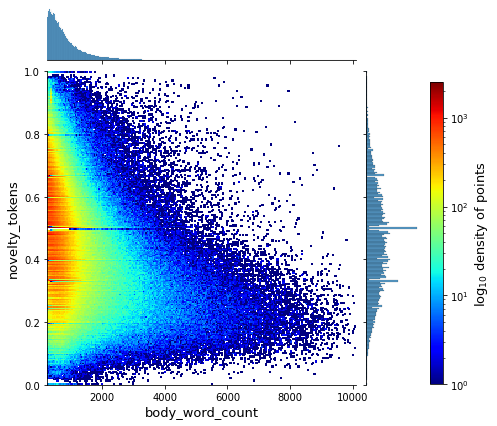

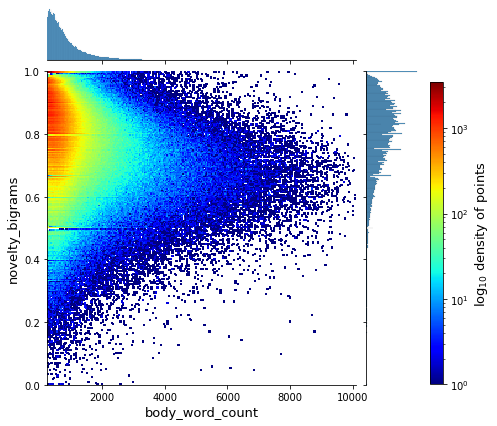

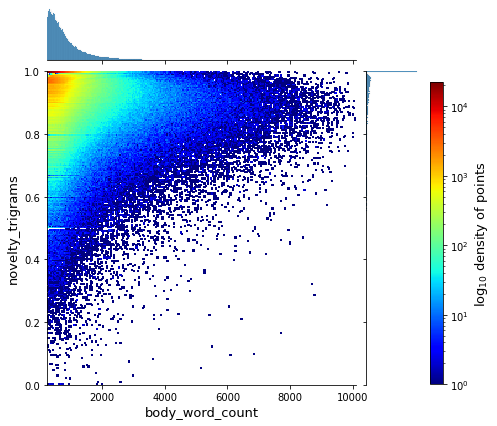

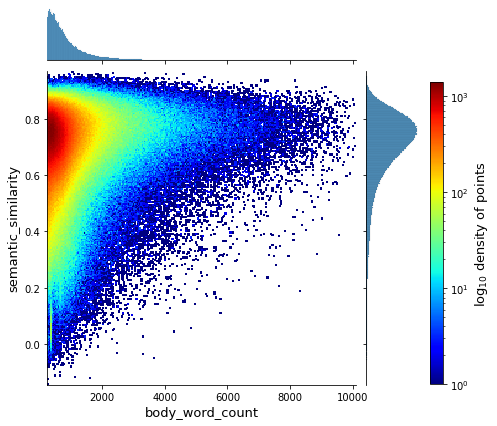

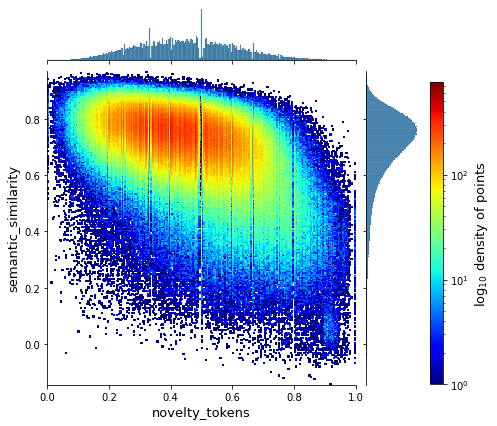

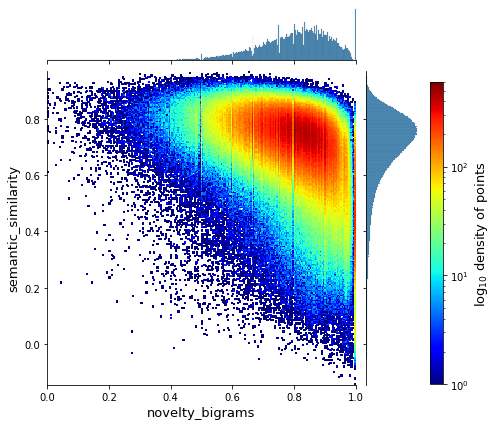

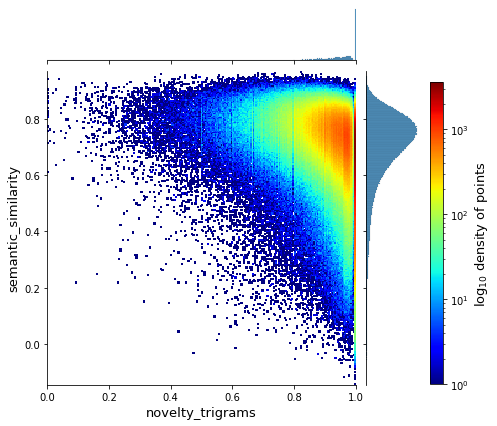

In [15]:
for var1, var2 in relevant_combinations:
    plot_joint(
        wiki_info_df,
        var1,
        var2,
        bins=(250, 250),
    )

# Sample text

In [16]:
def custom_query(where_statement: str = "", limit: int = 3) -> str:
    return f"""
    SELECT  wk.pageid
           ,wk.section_titles
           ,wk.summary
           ,wk.body_sections
           ,wk.section_word_count
           ,ar.title
           ,ar.summary_word_count
           ,ar.body_word_count
           ,nov.novelty_tokens
           ,nov.novelty_bigrams
           ,nov.novelty_trigrams
           ,sm.semantic_similarity
           
    FROM wiki_articles wk
    INNER JOIN wiki_article_novelty nov
        on wk.pageid = nov.pageid
    INNER JOIN article_level_info ar
        ON ar.pageid=nov.pageid
    INNER JOIN wiki_article_cosine_similarity sm
        ON ar.pageid=sm.pageid
    {where_statement}
    LIMIT {limit}
            
    """


def display_samples(samples):
    for sample in samples:
        (
            pageid,
            section_titles,
            summary,
            body_sections,
            section_word_count,
            title,
            summary_word_count,
            body_word_count,
            novelty_tokens,
            novelty_bigrams,
            novelty_trigrams,
            semantic_similarity,
        ) = sample

        body_sections = pickle.loads(body_sections)
        section_word_count = pickle.loads(section_word_count)
        section_titles = pickle.loads(section_titles)

        print("*" * 25, f"pageid: {pageid}, title: {title}", "*" * 25)

        stats = pd.DataFrame(
            data=[
                [
                    pageid,
                    title,
                    summary_word_count,
                    body_word_count,
                    novelty_tokens,
                    novelty_bigrams,
                    novelty_trigrams,
                    semantic_similarity,
                ]
            ],
        )
        stats.columns = ["pageid", "title"] + INFO_COLUMNS
        print("Stats")
        print("------")
        display(stats)

        print("summary")
        print("--------")
        print(summary)

        for idx, (sect_title, body_sect, word_count) in enumerate(
            zip(
                section_titles,
                body_sections,
                section_word_count,
            )
        ):
            print(f"section {idx}: {sect_title}, word count: {word_count}")
            print("-----------------------------------------------")
            print(body_sect)

## Semantic similarity

When looking at semantic similarity, the higher semantic similarity articles seem to keep not only in a specific topic but within the same niche in that topic. As we go lower, the themes seem to be more broad. The least semantically similar topics seam to talk about different topics relevant to the summary, i.e. a lot of them discuss books and novels where the body doesnt only contain a summary of the book but also history about its release, author, etc.

### High semantic similarity

In [17]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .9"))
display_samples(samples)

************************* pageid: 751, title: Aikido *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,751,Aikido,330,4605,0.3125,0.763889,0.955947,0.923471


summary
--------
 

 ( ,  , ) is a modern Japanese martial art that is split into many different styles, including Iwama Ryu, Iwama Shin Shin Aiki Shuren Kai, Shodokan Aikido, Yoshinkan, Aikikai and Ki Aikido. Aikido is now practiced in around 140 countries. It was originally developed by Morihei Ueshiba, as a synthesis of his martial studies, philosophy and religious beliefs. Ueshiba's goal was to create an art that practitioners could use to defend themselves while also protecting their attackers from injury. Aikido is often translated as the way of unifying (with) life energy or as the way of harmonious spirit. According to the founder's philosophy, the primary goal in the practice of aikido is to overcome oneself instead of cultivating violence or aggressiveness. Morihei Ueshiba used the phrase  to refer to this principle.

Mitsuteru Ueshiba at the 55th All Japan Aikido Demonstration held at the Nippon Budokan (May 2017)

Aikido's fundamental principles include:  (entering), ,  (br

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,2047,Alcoholics Anonymous,480,4889,0.478260869565217,0.799353,0.938272,0.901701


summary
--------
 

Alcoholics Anonymous (AA) is an international fellowship requiring no membership dues or fees dedicated to helping alcoholics peer to peer in sobriety through its spiritually inclined Twelve Steps program. Non-professional, non-denominational, self-supporting and apolitical, an avowed desire to stop drinking is its sole requirement for membership. Despite not endorsing the disease model of alcoholism, to which its program is nonetheless sympathetic, its wider acceptance is due in part to many AA members promulgating it. As of 2020, having spread to diverse cultures and geopolitical areas normally resistant to grassroots movements, AA has had an estimated worldwide membership of over two million with 75% of those in the U.S. and Canada.

AA began in 1935 with a newly sober Bill Wilson (Bill W.) first meeting Dr. Bob Smith M.D. (Dr. Bob), then detoxing in an Akron, Ohio hospital from alcohol abuse. Wilson put forth to Smith that alcoholism was not a failure of will or

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,2296,Adrenal gland,278,4436,0.118181818181818,0.618497,0.84127,0.91125


summary
--------
 

The adrenal glands (also known as suprarenal glands) are endocrine glands that produce a variety of hormones including adrenaline and the steroids aldosterone and cortisol. They are found above the kidneys. Each gland has an outer cortex which produces steroid hormones and an inner medulla. The adrenal cortex itself is divided into three main zones: the zona glomerulosa, the zona fasciculata and the zona reticularis.

The adrenal cortex produces three main types of steroid hormones: mineralocorticoids, glucocorticoids, and androgens. Mineralocorticoids (such as aldosterone) produced in the zona glomerulosa help in the regulation of blood pressure and electrolyte balance. The glucocorticoids cortisol and cortisone are synthesized in the zona fasciculata; their functions include the regulation of metabolism and immune system suppression. The innermost layer of the cortex, the zona reticularis, produces androgens that are converted to fully functional sex hormones in t

### Medium high semantic similarity

In [18]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .7 AND semantic_similarity <= .725"))
display_samples(samples)

************************* pageid: 12, title: Anarchism *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,12,Anarchism,357,6995,0.201388888888889,0.767773,0.936073,0.714916


summary
--------
 

Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be undesirable, unnecessary, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.

The history of anarchism goes back to prehistory, when humans lived in anarchic societies long before the establishment of formal states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose, but it was not until the 19th century that a self-conscious political movement emerged. During the latter half of the 19th and the first decades of the 20th century, the anarchist movement f

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,290,A,141,2014,0.28125,0.651163,0.863636,0.712492


summary
--------
 

A, or a, is the first letter and the first vowel letter of the modern English alphabet and the ISO basic Latin alphabet. Its name in English is a (pronounced ), plural aes. It is similar in shape to the Ancient Greek letter alpha, from which it derives. The uppercase version consists of the two slanting sides of a triangle, crossed in the middle by a horizontal bar. The lowercase version can be written in two forms: the double-storey a and single-storey ɑ. The latter is commonly used in handwriting and fonts based on it, especially fonts intended to be read by children, and is also found in italic type.

In the English grammar, a, and its variant an, are indefinite articles.


section 0: History, word count: 949
-----------------------------------------------


 Egyptian

 Phoenician aleph

 Semitic 

 Greek Alpha

 Etruscan A

 Latin/Cyrillic A

 Boeotian 800–700 BC

 Greek  Uncial

 Latin 300 AD  Uncial

 Egyptian hieroglyphic ox head

 Phoenician aleph

 Semitic 

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,649,Arraignment,102,1080,0.555555555555556,0.816667,0.933333,0.713399


summary
--------
 
Arraignment at the Ministries trial, 20 December 1947
Arraignment is a formal reading of a criminal charging document in the presence of the defendant, to inform them of the charges against them. In response to arraignment, the accused is expected to enter a plea. Acceptable pleas vary among jurisdictions, but they generally include guilty, not guilty, and the peremptory pleas (or pleas in bar) setting out reasons why a trial cannot proceed. Pleas of nolo contendere (no contest) and the Alford plea are allowed in some circumstances.


section 0: Australia, word count: 36
-----------------------------------------------


In Australia, arraignment is the first of eleven stages in a criminal trial, and involves the clerk of the court reading out the indictment. The judge will testify during the indictment process.


section 1: Canada, word count: 58
-----------------------------------------------


In every province in Canada except British Columbia, defendants are arra

### Medium Low semantic similarity

In [19]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .4 AND semantic_similarity <= .425"))
display_samples(samples)

************************* pageid: 1376, title: Army *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,1376,Army,414,3529,0.581818181818182,0.860806,0.99661,0.405991


summary
--------
 

Afghan Army soldiers on parade, 1950s

An army (from Latin arma arms, weapons via Old French armée, armed feminine), ground force or land force is a fighting force that fights primarily on land. In the broadest sense, it is the land-based military branch, service branch or armed service of a nation or state. It may also include aviation assets by possessing an army aviation component. Within a national military force, the word army may also mean a field army.

In some countries, such as France and China, the term army, especially in its plural form armies, has the broader meaning of armed forces as a whole, while retaining the colloquial sense of land forces. To differentiate the colloquial army from the formal concept of military force, the term is qualified, for example in France the land force is called Armée de terre, meaning Land Army, and the air and space force is called Armée de l'Air et de l’Espace, meaning Air and Space Army. The naval force, although not 

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,2950,Anyone Can Whistle,270,3336,0.287769784172662,0.689655,0.870056,0.408073


summary
--------
 
Anyone Can Whistle is a musical with music and lyrics by Stephen Sondheim, and a book by Arthur Laurents.

Described by theater historian Ken Mandelbaum as a satire on conformity and the insanity of the so-called sane, the show tells a story of an economically-depressed town whose corrupt Mayoress, in an attempt to draw tourists, decides to create a fake miracle - which draws the attention of Fay Apple, an emotionally inhibited nurse, a crowd of inmates from a local asylum called The Cookie Jar, and a doctor with secrets of his own.

Following a tryout period in Philadelphia, Anyone opened at the Majestic Theater on Broadway on April 4, 1964. The show received widely varied reviews (including negative notices from the New York Times and the New York Herald Tribune), and closed after a run of 12 previews and 9 performances.

In the decades since its closing, Anyone has not been produced on the scale of other Sondheim musicals; notable productions include a 1995 concer

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,3095,Amiga 500,188,3166,0.461538461538462,0.861111,0.947368,0.409205


summary
--------
 

The Amiga 500, also known as the A500, is the first low-end version of the Amiga home computer. It contains the same Motorola 68000 as the Amiga 1000, as well as the same graphics and sound coprocessors, but is in a smaller case similar to that of the Commodore 128.

Commodore announced the Amiga 500 at the January 1987 winter Consumer Electronics Showat the same time as the high-end Amiga 2000. It was initially available in the Netherlands in April 1987, then the rest of Europe in May. In North America and the UK it was released in October 1987 with a  list price. It competed directly against models in the Atari ST line.

The Amiga 500 was sold in the same retail outlets as the Commodore 64, as opposed to the computer store-only Amiga 1000. It proved to be Commodore's best-selling model, particularly in Europe. Although popular with hobbyists, arguably its most widespread use was as a gaming machine, where its graphics and sound were of significant benefit.


secti

### Low semantic similarity

In [20]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .15 AND semantic_similarity <= .25"))
display_samples(samples)

************************* pageid: 2080, title: A Fire Upon the Deep *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,2080,A Fire Upon the Deep,132,2328,0.558823529411765,0.866667,0.966667,0.245454


summary
--------
 

A Fire Upon the Deep is a 1992 science fiction novel by American writer Vernor Vinge. It is a space opera involving superhuman intelligences, aliens, variable physics, space battles, love, betrayal, genocide, and a communication medium resembling Usenet. A Fire Upon the Deep won the Hugo Award in 1993, sharing it with Doomsday Book by Connie Willis.

Besides the normal print book editions, the novel was also included on a CD-ROM sold by ClariNet Communications along with the other nominees for the 1993 Hugo awards. The CD-ROM edition included numerous annotations by Vinge on his thoughts and intentions about different parts of the book, and was later released as a standalone e-book (no longer available).


section 0: Setting, word count: 1001
-----------------------------------------------

The novel is set in various locations in the Milky Way. The galaxy is divided into four concentric volumes called the Zones of Thought; it is not clear to the novel's characters 

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,3912,List of major biblical figures,66,445,0.914285714285714,1,1,0.233727


summary
--------
 
The Bible is a canonical collection of texts considered sacred in Judaism or Christianity. Different religious groups include different books within their canons, in different orders, and sometimes divide or combine books, or incorporate additional material into canonical books. Christian Bibles range from the sixty-six books of the Protestant canon to the eighty-one books of the Ethiopian Orthodox Church canon.


section 0: Hebrew Bible, word count: 86
-----------------------------------------------


Prophets.

Kings.

Solomon

Priests.
 Aaron
 Eleazar
 Eli
 Phinehas

Tribes of Israel.
According to the Book of Genesis, the Israelites were descendants of the sons of Jacob, who was renamed Israel after wrestling with an angel. His twelve male children become the ancestors of the Twelve Tribes of Israel.

 Asher
 Benjamin
 Dan
 Gad
 Issachar
 Joseph, which was split into two tribes descended from his sons:
 Tribe of Ephraim
 Tribe of Menasheh
 Judah
 Levi
 Naphtali
 R

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,24913,Playdia,130,613,0.787878787878788,0.930233,0.952941,0.245799


summary
--------
 

The  (developed under the codename BA-X) is a fifth-generation home video game console released exclusively in Japan in 1994 at the initial price of ¥24,800. It was intended for a young audience and, like many consoles of the era (e.g. the LaserActive and the 3DO Interactive Multiplayer), was marketed more as a multimedia home entertainment system than as a dedicated gaming console, with anime quiz software and edutainment making up most of the game library.  The Playdia uses a single infrared joypad with simple controls. Bandai, the Playdia's manufacturer, was the only software publisher to support this console (except for VAP who published Ie Naki Ko - Suzu no Sentaku instead of Bandai).


section 0: Playdia title complete list, word count: 447
-----------------------------------------------


1994 (11 titles).
 09/23 - Dragon Ball Z - Shin Saiyajin Zetsumetsu Keikaku Chikyū Hen - BAPD-01
 09/23 - Bishōjo Senshi Sailor Moon S - Quiz Taiketsu! Sailor Power Kesshū



### Low semantic similarity

In [21]:
samples = retrieve_query(custom_query("WHERE semantic_similarity <= .1"))
display_samples(samples)

************************* pageid: 8567, title: Dune Messiah *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,8567,Dune Messiah,82,1369,0.189189189189189,0.510204,0.557692,0.033389


summary
--------
 
Dune Messiah is a science fiction novel by American writer Frank Herbert, the second in his Dune series of six novels. A sequel to Dune (1965), it was originally serialized in Galaxy magazine in 1969, and then published by Putnam the same year. Dune Messiah and its own sequel Children of Dune (1976) were collectively adapted by the Sci-Fi Channel in 2003 into a miniseries entitled Frank Herbert's Children of Dune.


section 0: Plot summary, word count: 974
-----------------------------------------------


Twelve years after the events described in Dune (1965), Paul Muad'Dib Atreides rules as Emperor. By accepting the role of messiah to the Fremen, Paul had unleashed a jihad which conquered most of the known universe. Paul is the most powerful emperor ever known, but is powerless to stop the lethal excesses of the religious juggernaut he has created. Although 61 billion people have perished, Paul's prescient visions indicate that this is far from the worst possible ou

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,35385,636,56,627,0.806451612903226,0.973684,1,0.025383


summary
--------
 

Year 636    (DCXXXVI) was a leap year starting on Monday (link will display the full calendar) of the Julian calendar. The denomination 636 for this year has been used since the early medieval period, when the Anno Domini calendar era became the prevalent method in Europe for naming years.


section 0: Events, word count: 504
-----------------------------------------------


By place.

Byzantine Empire.
 Arab–Byzantine War: Emperor Heraclius assembles a large army (100,000 men) consisting of contingents of Byzantines, Slavs, Franks, Georgians, Armenians, and Christian Arabs. He establishes a base at Yaqusah (near Gadara), close to the edge of the Golan Heights, protecting the vital main road from Egypt to Damascus. The base is protected by deep valleys and precipitous cliffs, well supplied with water and grazing.
 Summer – Heraclius summons a church assembly at Antioch, and scrutinises the situation. He accepts the argument that Byzantine disobedience to God is to b

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,35392,626,63,1057,0.694444444444444,0.930233,1,0.045304


summary
--------
 

Tai Zong of the Tang dynasty
__NOTOC__
Year 626 (DCXXVI) was a common year starting on Wednesday (link will display the full calendar) of the Julian calendar. The denomination 626 for this year has been used since the early medieval period, when the Anno Domini calendar era became the prevalent method in Europe for naming years.


section 0: Events, word count: 853
-----------------------------------------------


By place.
Byzantine Empire.
 Siege of Constantinople: A horde of Avars, consisting of about 80,000 men (including large contingents of Slavs, Bulgars, and other barbarians), attack the walls of Constantinople. A small Persian army arrives on the Bosphorus, on the Asiatic side. The Theodosian Walls are stormed with the most up-to-date siege equipment, in the form of traction trebuchets. The Avars have also mobile armoured shelters (medieval sows') and siege towers; the latter are covered in hides for fire protection. The defense of the capital (12,000 well-

## Novelty
###  High novelty

In [22]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .90"))
display_samples(samples)

************************* pageid: 3912, title: List of major biblical figures *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,3912,List of major biblical figures,66,445,0.914285714285714,1,1,0.233727


summary
--------
 
The Bible is a canonical collection of texts considered sacred in Judaism or Christianity. Different religious groups include different books within their canons, in different orders, and sometimes divide or combine books, or incorporate additional material into canonical books. Christian Bibles range from the sixty-six books of the Protestant canon to the eighty-one books of the Ethiopian Orthodox Church canon.


section 0: Hebrew Bible, word count: 86
-----------------------------------------------


Prophets.

Kings.

Solomon

Priests.
 Aaron
 Eleazar
 Eli
 Phinehas

Tribes of Israel.
According to the Book of Genesis, the Israelites were descendants of the sons of Jacob, who was renamed Israel after wrestling with an angel. His twelve male children become the ancestors of the Twelve Tribes of Israel.

 Asher
 Benjamin
 Dan
 Gad
 Issachar
 Joseph, which was split into two tribes descended from his sons:
 Tribe of Ephraim
 Tribe of Menasheh
 Judah
 Levi
 Naphtali
 R

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,4480,BC,59,394,0.911764705882353,1,1,0.518731


summary
--------
 

BC most often refers to:

 Before Christ, a calendar era based on the traditionally reckoned year of the birth of Jesus of Nazareth
 British Columbia, the westernmost province of Canada
 Baja California, a state of Mexico
 Before COVID-19, depicting the normalcy of life before the COVID-19 pandemic started

BC may also refer to:    


section 0: Arts and entertainment, word count: 53
-----------------------------------------------

 B.C., a song by Sparks from the 1974 album Propaganda
 B.C. (comic strip) by Johnny Hart, and one of its characters
 BC (video game) by Lionhead Studios
 BC The Archaeology of the Bible Lands, a BBC television series
 Bullet Club, a professional wrestling stable


section 1: Businesses and organizations, word count: 50
-----------------------------------------------

 Basilian Chouerite Order of Saint John the Baptist, an order of the Greek Catholic Church
 BC Card, a Korean credit card company
 Bella Center, a conference center in Copen

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,10231,List of economists,49,276,1.0,1,1,0.461651


summary
--------
 
This is an incomplete alphabetical list by surname of notable economists, experts in the social science of economics, past and present. For a history of economics, see the article History of economic thought. Only economists with biographical articles in Wikipedia are listed here.


section 0: A, word count: 20
-----------------------------------------------

Thomas Attwood
Sir William Ashley
B. R. Ambedkar
George Akerlof
Kenneth Arrow
Maurice Allais
Robert Aumann
Edmund Burke
Mikhail Bakunin


section 1: B, word count: 28
-----------------------------------------------

Jean Bodin
Frédéric Bastiat
Eugen Böhm von Bawerk
Gary Becker
Fischer Black
James M. Buchanan
Ben Bernanke
Walter Block
Francine D. Blau
Olivier Blanchard
Willem Buiter
Ali Babacan


section 2: C, word count: 19
-----------------------------------------------

Thomas Chalmers
Henry Charles Carey
John Bates Clark
Gustav Cassel
John R. Commons
Attilio Celant
Agustin Carstens
Ha-Joon Chang


section 3: 

In [23]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .85 AND novelty_tokens < .90"))
display_samples(samples)

************************* pageid: 6941, title: Colin Kapp *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,6941,Colin Kapp,86,318,0.86,0.953125,0.984615,0.260974


summary
--------
 
Derek Ivor Colin Kapp (3 April 1928 – 3 August 2007), Known as Colin Kapp, was a British science fiction author best known for his stories about the Unorthodox Engineers.

As an electronic engineer, he began his career with Mullard Electronics then specialised in electroplating techniques, eventually becoming a freelance consultant engineer.

He was born in Southwark, south London, 3 April 1928 to John L. F. Kapp and Annie M.A. (née Towner).


section 0: Works, word count: 318
-----------------------------------------------


Cageworld series.

 Search for the sun! (1982) (also published as Cageworld)
 The Lost worlds of Cronus (1982)
 The Tyrant of Hades (1984)
 Star Search (1984)

Chaos series.
 The Patterns of Chaos (1972)
 The Chaos Weapon (1977)

Standalone novels.
 The Dark Mind (1964) (also published as Transfinite Man)
 The Wizard of Anharitte (1973)
 The Survival Game (1976)
 Manalone (1977)
 The Ion War (1978)
 The Timewinders (1980)

Short stories.

Unorth

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,10472,Elyssa Davalos,81,393,0.880952380952381,1,1,0.147236


summary
--------
 

Elyssa Davalos (born May 30, 1959) is a former American television and movie actress. Her father was actor Richard Davalos and her sister is musician Dominique Davalos. She is the mother of actress Alexa Davalos, from her marriage to photographer Jeff Dunas. She is of Spanish and Finnish descent on her father's side. Her family name would be spelled originally Dávalos in Spanish, with an accent on the first a.


section 0: Filmography, word count: 393
-----------------------------------------------


Film.

 Year

 Title

 Role

 Notes

1973



Paula Kelly

1979



Millie Gaskill

1980

Herbie Goes Bananas

Melissa

1993



Sondra Rankin

1999

Tycus

Crying Woman

Video

2000

Urban Chaos Theory

The Mistress

Short

2002

Two Paths

Sally

Short

2003

Between the Sheets

Layla

2007

Nancy Drew

Twin Palms Manager

Television.

 Year

 Title

 Role

 Notes

1975

Three for the Road

Sophie Gianelli

Adventure in Los Angeles

1976

ABC Afterschool Special

Linda



,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,13526,List of Roman place names in Britain,124,1331,0.884615384615385,0.961538,1,0.58825


summary
--------
 
Roman Britain. Map from 1911 Encyclopædia Britannica

A partial list of Roman place names in Great Britain.

This list includes only names documented from Roman times. For a more complete list including later Latin names, see List of Latin place names in Britain.

The early sources for Roman names show numerous variants and misspellings of the Latin names. Moreover, one of the principal authorities, Ptolemy, wrote in Greek so names that he records need to be transliterated back into Latin to reveal the original form.

Note that in general only one source is shown below for each name, although many of the names are recorded in more than one of the sources.


section 0: Lists, word count: 1331
-----------------------------------------------


Geographic regions.

Roman name

Modern region

Appearance

Britannia

Great Britain

T

Hibernia

Ireland

T

Caledonia

Scotland

T

Settlement names.

Roman name

 Modern name

Appearances

Aballava

Burgh by Sands, Cumbria

ND

In [24]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .76 AND novelty_tokens < .85"))
display_samples(samples)

************************* pageid: 579, title: Alien *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,579,Alien,80,686,0.771428571428571,0.93617,0.98,0.468581


summary
--------
 

Alien primarily refers to:
 Alien (law), a person in a country who is not a national of that country
 Enemy alien, the above in times of war
 Extraterrestrial life, life which does not originate from Earth
 Specifically, intelligent extraterrestrial beings; see List of alleged extraterrestrial beings
 Introduced species, a species not native to its environment

Alien(s), or The Alien(s) may also refer to:


section 0: Science and technology, word count: 26
-----------------------------------------------

 AliEn (ALICE Environment), a grid framework
 Alien (file converter), a Linux program
 Alien Technology, a manufacturer of RFID technology


section 1: Arts and entertainment, word count: 635
-----------------------------------------------

 Alien (franchise), a media franchise
 Alien (creature in Alien franchise)

Films.
 Alien (film), a 1979 film by Ridley Scott
 Aliens (film), second film in the franchise from 1986 by James Cameron
 Alien 3, third film in the fra

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,1428,Adrian,187,3186,0.802469135802469,0.972727,1,0.295537


summary
--------
 

Adrian is a form of the Latin given name Adrianus or Hadrianus. Its ultimate origin is most likely via the former river Adria from the Venetic and Illyrian word adur, meaning sea or water.

The Adria was until the 8th century BC the main channel of the Po River into the Adriatic Sea but ceased to exist before the 1st century BC. Hecataeus of Miletus (c.550 - c.476 BC) asserted that both the Etruscan harbor city of Adria and the Adriatic Sea had been named after it. Emperor Hadrian's family was named after the city or region of Adria/Hadria, now Atri, in Picenum, which most likely started as an Etruscan or Greek colony of the older harbor city of the same name. 

Several saints and six popes have borne this name, including the only English pope, Adrian IV, and the only Dutch pope, Adrian VI. As an English name, it has been in use since the Middle Ages, although it did not become common until modern times.


section 0: Religion, word count: 225
-----------------------

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,2487,Amazonite,153,672,0.803030303030303,0.965116,1,0.707485


summary
--------
 

Amazonite, also known as Amazonstone, is a green tectosilicate mineral, a variety of the potassium feldspar called microcline. Its chemical formula is KAlSi3O8, which is polymorphic to orthoclase.

Its name is taken from that of the Amazon River, from which green stones were formerly obtained, though it is unknown whether those stones were amazonite. Although it has been used for over two thousand years, as attested by archaeological finds in Egypt and Mesopotamia, no ancient or medieval authority mentions it. It was first described as a distinct mineral only in the 18th century.

Green and greenish-blue varieties of potassium feldspars that are predominantly triclinic are designated
as amazonite. It has been described as a beautiful crystallized variety of a bright verdigris-green and as possessing a lively green colour. It is occasionally cut and used as a gemstone.


section 0: Occurrence, word count: 205
-----------------------------------------------


Amazonit

In [25]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .60 AND novelty_tokens < .7"))
display_samples(samples)

************************* pageid: 332, title: Animalia (book) *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,332,Animalia (book),63,319,0.676470588235294,0.926829,1,0.697977


summary
--------
 

Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over four million copies have been sold worldwide.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.


section 0: Synopsis, word count: 99
-----------------------------------------------

Animalia is an alliterative alphabet book and contains twenty-six illustrations, one for each letter of the alphabet. Each illustration features an animal from the animal kingdom (A is for alligator and armadillo, B is for butterfly, etc.) along with a short poem utilizing the letter of the page for many of the words. The illustrations contain many other objects beginning with that letter that the reader can try to identify. As an additional challenge, the author has hidden a picture of himself as a child in every picture.


section 1: Relat

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,734,Actinopterygii,200,2570,0.662921348314607,0.902256,0.992857,0.766985


summary
--------
 

Actinopterygii  (New Latin  ('having rays') + Greek  ( wing, fins')), members of which are known as ray-finned fishes, is a clade (traditionally class or subclass) of the bony fishes.

The ray-finned fishes are so-called because their fins are webs of skin supported by bony or horny spines (rays), as opposed to the fleshy, lobed fins that characterize the class Sarcopterygii (lobe-finned fish). These actinopterygian fin rays attach directly to the proximal or basal skeletal elements, the radials, which represent the link or connection between these fins and the internal skeleton (e.g., pelvic and pectoral girdles).

By species count, actinopterygians dominate the vertebrates, and they comprise nearly 99% of the over 30,000 species of fish. They are ubiquitous throughout freshwater and marine environments from the deep sea to the highest mountain streams. Extant species can range in size from Paedocypris, at , to the massive ocean sunfish, at , and the long-bodied oa

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,764,Agnostida,56,457,0.612903225806452,0.916667,1,0.702051


summary
--------
 

Agnostida is an order of arthropod which first developed near the end of the Early Cambrian period and thrived during the Middle Cambrian. They are present in the Lower Cambrian fossil record along with trilobites from the Redlichiida, Corynexochida, and Ptychopariida orders. The last agnostids went extinct in the Late Ordovician.


section 0: Systematics, word count: 208
-----------------------------------------------

The Agnostida are divided into two suborders — Agnostina and Eodiscina — which  are then subdivided into a number of families. As a group, agnostids are isopygous, meaning their pygidium is similar in size and shape to their cephalon. Most agnostid species were eyeless.

The systematic position of the order Agnostida within the class Trilobita remains uncertain, and there has been continuing debate whether they are trilobites or a stem group. The challenge to the status has focused on Agnostina partly due to the  juveniles of one genus have been foun

###  Medium novelty

In [26]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .5 AND novelty_tokens < .6"))
display_samples(samples)

************************* pageid: 334, title: International Atomic Time *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,334,International Atomic Time,189,1082,0.524390243902439,0.82906,0.944444,0.761364


summary
--------
 

International Atomic Time (TAI, from the French name ) is a high-precision atomic coordinate time standard based on the notional passage of proper time on Earth's geoid. It is the principal realisation of Terrestrial Time (with a fixed offset of epoch). It is also the basis for Coordinated Universal Time (UTC), which is used for civil timekeeping all over the Earth's surface. , when another leap second was added, TAI is currently exactly 37 seconds ahead of Unix time. The 37 seconds results from the initial difference of 10 seconds at the start of 1972, plus 27 leap seconds in UTC since 1972.

TAI may be reported using traditional means of specifying days, carried over from non-uniform time standards based on the rotation of the Earth. Specifically, both Julian days and the Gregorian calendar are used. TAI in this form was synchronised with Universal Time at the beginning of 1958, and the two have drifted apart ever since, due to the changing motion of the Earth.




,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,572,Agricultural science,45,599,0.565217391304348,0.925926,1,0.614694


summary
--------
 

Agricultural science is a broad multidisciplinary field of biology that encompasses the parts of exact, natural, economic and social sciences that are used in the practice and understanding of agriculture. Professionals of the agricultural science are called agricultural scientists or agriculturists.


section 0: History, word count: 142
-----------------------------------------------


In the 18th century, Johann Friedrich Mayer conducted experiments on the use of gypsum (hydrated calcium sulphate) as a fertilizer.

In 1843, John Lawes and Joseph Henry Gilbert began a set of long-term field experiments at Rothamsted Research Station in England, some of which are still running as of 2018.

In the United States, a scientific revolution in agriculture began with the Hatch Act of 1887, which used the term agricultural science. The Hatch Act was driven by farmers' interest in knowing the constituents of early artificial fertilizer. The Smith-Hughes Act of 1917 shifted a

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,580,Astronomer,106,683,0.528301886792453,0.915493,1,0.642406


summary
--------
 

The Astronomer, 1668, by Johannes Vermeer

An astronomer is a scientist in the field of astronomy who focuses their studies on a specific question or field outside the scope of Earth. They observe astronomical objects such as stars, planets, moons, comets and galaxies – in either observational (by analyzing the data) or theoretical astronomy. Examples of topics or fields astronomers study include planetary science, solar astronomy, the origin or evolution of stars, or the formation of galaxies. Related but distinct subjects like physical cosmology, which studies the Universe as a whole.


section 0: Types, word count: 127
-----------------------------------------------

Astronomers usually fall under either of two main types: observational and theoretical. Observational astronomers make direct observations of celestial objects and analyze the data. In contrast, theoretical astronomers create and investigate models of things that cannot be observed. Because it takes 

In [27]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .4 AND novelty_tokens < .5"))
display_samples(samples)

************************* pageid: 39, title: Albedo *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,39,Albedo,384,3042,0.429487179487179,0.851695,0.968992,0.680077


summary
--------
 

diffusely reflected sunlight relative to various surface conditions

Albedo (; ) is the measure of the diffuse reflection of solar radiation out of the total solar radiation and measured on a scale from 0, corresponding to a black body that absorbs all incident radiation, to 1, corresponding to a body that reflects all incident radiation.

Surface albedo is defined as the ratio of radiosity Je to the irradiance Ee (flux per unit area) received by a surface. The proportion reflected is not only determined by properties of the surface itself, but also by the spectral and angular distribution of solar radiation reaching the Earth's surface. These factors vary with atmospheric composition, geographic location and time (see position of the Sun). While bi-hemispherical reflectance is calculated for a single angle of incidence (i.e., for a given position of the Sun), albedo is the directional integration of reflectance over all solar angles in a given period. The temporal 

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,309,An American in Paris,162,1765,0.414634146341463,0.839623,0.981651,0.82983


summary
--------
 

An American in Paris is a jazz-influenced orchestral piece by American composer George Gershwin first performed in 1928. It was inspired by the time that Gershwin had spent in Paris and evokes the sights and energy of the French capital during the Années folles.

Gershwin scored the piece for the standard instruments of the symphony orchestra plus celesta, saxophones, and automobile horns. He brought back four Parisian taxi horns for the New York premiere of the composition, which took place on December 13, 1928, in Carnegie Hall, with Walter Damrosch conducting the New York Philharmonic. It was Damrosch who had commissioned Gershwin to write his Concerto in F following the earlier success of Rhapsody in Blue (1924). He completed the orchestration on November 18, less than four weeks before the work's premiere. He collaborated on the original program notes with critic and composer Deems Taylor.


section 0: Background, word count: 343
-------------------------------

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,330,Actrius,57,350,0.424242424242424,0.837838,0.921053,0.656906


summary
--------
 

Actresses (Catalan: Actrius) is a 1997 Catalan language Spanish drama film produced and directed by Ventura Pons and based on the award-winning stage play E.R. by Josep Maria Benet i Jornet. The film has no male actors, with all roles played by females. The film was produced in 1996. 


section 0: Synopsis, word count: 67
-----------------------------------------------

In order to prepare herself to play a role commemorating the life of legendary actress Empar Ribera, young actress (Mercè Pons) interviews three established actresses who had been the Ribera's pupils: the international diva Glòria Marc (Núria Espert), the television star Assumpta Roca (Rosa Maria Sardà), and dubbing director Maria Caminal (Anna Lizaran).


section 1: Cast, word count: 20
-----------------------------------------------

 Núria Espert as Glòria Marc
 Rosa Maria Sardà as Assumpta Roca
 Anna Lizaran as Maria Caminal
 Mercè Pons as Estudiant


section 2: Recognition, word count: 263
-----

###  Medium novelty low

In [28]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .3 AND novelty_tokens < .4"))
display_samples(samples)

************************* pageid: 336, title: Altruism *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,336,Altruism,427,7039,0.32967032967033,0.821429,0.962406,0.732014


summary
--------
 

Giving alms to the poor is often considered an altruistic action.

Altruism is the principle and moral practice of concern for happiness of other human beings or other animals, resulting in a quality of life both material and spiritual. It is a traditional virtue in many cultures and a core aspect of various religious traditions and secular worldviews, though the concept of others toward whom concern should be directed can vary among cultures and religions. In an extreme case, altruism may become a synonym of selflessness, which is the opposite of selfishness.

The word altruism was popularized (and possibly coined) by the French philosopher Auguste Comte in French, as altruisme, for an antonym of egoism. He derived it from the Italian altrui, which in turn was derived from Latin alteri, meaning other people or somebody else.

Altruism in biological observations in field populations of the day organisms is an individual performing an action which is at a cost to the

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,340,Alain Connes,61,310,0.388888888888889,0.804878,0.902439,0.794861


summary
--------
 

Alain Connes (; born 1 April 1947) is a French mathematician, and a theoretical physicist, known for his contributions to the study of operator algebras and noncommutative geometry. He is a Professor at the Collège de France, IHÉS, Ohio State University and Vanderbilt University. He was awarded the Fields Medal in 1982.


section 0: Career, word count: 128
-----------------------------------------------


Connes was an Invited Professor at the Conservatoire national des arts et métiers (2000).

Research.
Alain Connes studies operator algebras. In his early work on von Neumann algebras in the 1970s, he succeeded in obtaining the almost complete classification of injective factors. He also formulated the Connes embedding problem. Following this, he made contributions in operator K-theory and index theory, which culminated in the Baum–Connes conjecture. He also introduced cyclic cohomology in the early 1980s as a first step in the study of noncommutative differential g

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,593,Animation,333,6388,0.340277777777778,0.755656,0.961207,0.568401


summary
--------
 

Animation is a method in which figures are manipulated to appear as moving images. In traditional animation, images are drawn or painted by hand on transparent celluloid sheets to be photographed and exhibited on film. Today, most animations are made with computer-generated imagery (CGI). Computer animation can be very detailed 3D animation, while 2D computer animation (which may have the look of traditional animation) can be used for stylistic reasons, low bandwidth, or faster real-time renderings. Other common animation methods apply a stop motion technique to two and three-dimensional objects like paper cutouts, puppets, or clay figures.

Commonly, the effect of the animation is achieved by a rapid succession of sequential images that minimally differ from each other. The illusion—as in motion pictures in general—is thought to rely on the phi phenomenon and beta movement, but the exact causes are still uncertain.
Analog mechanical animation media that rely on the

In [29]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .25 AND novelty_tokens < .3"))
display_samples(samples)

************************* pageid: 290, title: A *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,290,A,141,2014,0.28125,0.651163,0.863636,0.712492


summary
--------
 

A, or a, is the first letter and the first vowel letter of the modern English alphabet and the ISO basic Latin alphabet. Its name in English is a (pronounced ), plural aes. It is similar in shape to the Ancient Greek letter alpha, from which it derives. The uppercase version consists of the two slanting sides of a triangle, crossed in the middle by a horizontal bar. The lowercase version can be written in two forms: the double-storey a and single-storey ɑ. The latter is commonly used in handwriting and fonts based on it, especially fonts intended to be read by children, and is also found in italic type.

In the English grammar, a, and its variant an, are indefinite articles.


section 0: History, word count: 949
-----------------------------------------------


 Egyptian

 Phoenician aleph

 Semitic 

 Greek Alpha

 Etruscan A

 Latin/Cyrillic A

 Boeotian 800–700 BC

 Greek  Uncial

 Latin 300 AD  Uncial

 Egyptian hieroglyphic ox head

 Phoenician aleph

 Semitic 

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,573,Alchemy,433,7878,0.255102040816327,0.792115,0.95189,0.814432


summary
--------
 

Kimiya-yi sa'ādat (The Alchemy of Happiness), a text on Islamic philosophy and alchemy by the Persian philosopher and mystic Al-Ghazālī (11th century)
Depiction of Ouroboros from the alchemical treatise Aurora consurgens (15th century), Zentralbibliothek Zürich, Switzerland

Alchemy (from Arabic: al-kīmiyā; from Ancient Greek: khumeía) is an ancient branch of natural philosophy, a philosophical and protoscientific tradition that was historically practiced in China, India, the Muslim world, and Europe. In its Western form, alchemy is first attested in a number of pseudepigraphical texts written in Greco-Roman Egypt during the first few centuries CE.

Alchemists attempted to purify, mature, and perfect certain materials. Common aims were chrysopoeia, the transmutation of base metals (e.g., lead) into noble metals (particularly gold); the creation of an elixir of immortality; and the creation of panaceas able to cure any disease. The perfection of the human body and so

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,639,Alkane,501,7596,0.287234042553192,0.763934,0.961424,0.741846


summary
--------
 

Chemical structure of methane, the simplest alkane
In organic chemistry, an alkane, or paraffin (a historical trivial name that also has other meanings), is an acyclic saturated hydrocarbon. In other words, an alkane consists of hydrogen and carbon atoms arranged in a tree structure in which all the carbon–carbon bonds are single. Alkanes have the general chemical formula CnH2n+2. The alkanes range in complexity from the simplest case of methane (CH4), where n = 1 (sometimes called the parent molecule), to arbitrarily large and complex molecules, like pentacontane (C50H102) or 6-ethyl-2-methyl-5-(1-methylethyl) octane, an isomer of tetradecane (C14H30).

The International Union of Pure and Applied Chemistry (IUPAC) defines alkanes as acyclic branched or unbranched hydrocarbons having the general formula n2n+2, and therefore consisting entirely of hydrogen atoms and saturated carbon atoms. However, some sources use the term to denote any saturated hydrocarbon, includ

###   Low novelty

In [30]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .15 AND novelty_tokens < .25"))
display_samples(samples)

************************* pageid: 12, title: Anarchism *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,12,Anarchism,357,6995,0.201388888888889,0.767773,0.936073,0.714916


summary
--------
 

Anarchism is a political philosophy and movement that is sceptical of authority and rejects all involuntary, coercive forms of hierarchy. Anarchism calls for the abolition of the state, which it holds to be undesirable, unnecessary, and harmful. As a historically left-wing movement, placed on the farthest left of the political spectrum, it is usually described alongside libertarian Marxism as the libertarian wing (libertarian socialism) of the socialist movement, and has a strong historical association with anti-capitalism and socialism.

The history of anarchism goes back to prehistory, when humans lived in anarchic societies long before the establishment of formal states, realms, or empires. With the rise of organised hierarchical bodies, scepticism toward authority also rose, but it was not until the 19th century that a self-conscious political movement emerged. During the latter half of the 19th and the first decades of the 20th century, the anarchist movement f

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,25,Autism,398,7395,0.193548387096774,0.660584,0.896057,0.773453


summary
--------
 

Autism is a neurodevelopmental disorder characterized by difficulties with social interaction and communication, and by restricted and repetitive behavior. Parents often notice signs during the first three years of their child's life. These signs often develop gradually, though some autistic children experience regression in their communication and social skills after reaching developmental milestones at a normal pace.

Autism is associated with a combination of genetic and environmental factors. Risk factors during pregnancy include certain infections, such as rubella, toxins including valproic acid, alcohol, cocaine, pesticides, lead, and air pollution, fetal growth restriction, and autoimmune diseases. Controversies surround other proposed environmental causes; for example, the vaccine hypothesis, which has been disproven. Autism affects information processing in the brain and how nerve cells and their synapses connect and organize; how this occurs is not well un

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,640,Appellate procedure in the United States,277,3767,0.204301075268817,0.691358,0.91954,0.757579


summary
--------
 

Court of Appeals in Washington, D.C.

United States appellate procedure involves the rules and regulations for filing appeals in state courts and federal courts. The nature of an appeal can vary greatly depending on the type of case and the rules of the court in the jurisdiction where the case was prosecuted. There are many types of standard of review for appeals, such as de novo and abuse of discretion. However, most appeals begin when a party files a petition for review to a higher court for the purpose of overturning the lower court's decision.

An appellate court is a court that hears cases on appeal from another court. Depending on the particular legal rules that apply to each circumstance, a party to a court case who is unhappy with the result might be able to challenge that result in an appellate court on specific grounds. These grounds typically could include errors of law, fact, procedure or due process. In different jurisdictions, appellate courts are also

In [31]:
samples = retrieve_query(custom_query("WHERE novelty_tokens < .15"))
display_samples(samples)

************************* pageid: 595, title: Andre Agassi *************************
Stats
------


,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,595,Andre Agassi,506,9765,0.132596685082873,0.598639,0.795796,0.825522


summary
--------
 

Andre Kirk Agassi ( ; born April 29, 1970) is an American former world No. 1 tennis player. In singles, Agassi is an eight-time Grand Slam champion and a 1996 Olympic gold medalist, as well as a runner-up in seven other Grand Slam tournaments.

During the Open Era, Agassi was the first man to win four Australian Open singles titles, a record later surpassed by Novak Djokovic when he won his fifth title in 2015. Agassi is the second of five male singles players to achieve the Career Grand Slam in the Open Era after Rod Laver and before Roger Federer, Rafael Nadal and Djokovic; he is the fifth of eight in history to make the achievement. He is also the first of two men to achieve the Career Golden Slam (Career Grand Slam and Olympic gold medal), the other being Nadal, and the only man to win a Career Super Slam (Career Grand Slam, plus the Olympic gold medal, plus the ATP Tour Finals). He is the only man in history to win the seven biggest titles in the sport the Aust

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,899,Actinium,294,3196,0.106060606060606,0.531579,0.726804,0.813207


summary
--------
 

Actinium is a chemical element with the symbol Ac and atomic number 89. It was first isolated by Friedrich Oskar Giesel in 1902, who gave it the name emanium; the element got its name by being wrongly identified with a substance André-Louis Debierne found in 1899 and called actinium. Actinium gave the name to the actinide series, a group of 15 similar elements between actinium and lawrencium in the periodic table. Together with polonium, radium, and radon, actinium was one of the first non-primordial radioactive elements to be isolated.

A soft, silvery-white radioactive metal, actinium reacts rapidly with oxygen and moisture in air forming a white coating of actinium oxide that prevents further oxidation. As with most lanthanides and many actinides, actinium assumes oxidation state +3 in nearly all its chemical compounds. Actinium is found only in traces in uranium and thorium ores as the isotope 227Ac, which decays with a half-life of 21.772 years, predominantly e

,pageid,title,summary_word_count,body_word_count,novelty_tokens,novelty_bigrams,novelty_trigrams,semantic_similarity
0,900,Americium,318,6109,0.146666666666667,0.535354,0.842365,0.778366


summary
--------
 

Americium is a synthetic radioactive chemical element with the symbol Am and atomic number 95. It is a transuranic member of the actinide series, in the periodic table located under the lanthanide element europium, and thus by analogy was named after the Americas.

Americium was first produced in 1944 by the group of Glenn T. Seaborg from Berkeley, California, at the Metallurgical Laboratory of the University of Chicago, as part of the Manhattan Project. Although it is the third element in the transuranic series, it was discovered fourth, after the heavier curium. The discovery was kept secret and only released to the public in November 1945. Most americium is produced by uranium or plutonium being bombarded with neutrons in nuclear reactors – one tonne of spent nuclear fuel contains about 100 grams of americium. It is widely used in commercial ionization chamber smoke detectors, as well as in neutron sources and industrial gauges. Several unusual applications, such

# To keep

In [32]:
to_keep = wiki_info_df[
    (wiki_info_df["semantic_similarity"] > 0.4)
    & (wiki_info_df["novelty_tokens"] <= 0.5)
]
print(len(to_keep))
len(to_keep) / len(wiki_info_df)

874759


0.6142750505424314

# TODO: check markup wikipedia clean up